# Main topic modeling notebook using lda2vec and seaborn visualizations
### Model trained by wikipedia pages of top 500 SnP companies
### All data about test documents is loaded from an Excel workbook called GoogleNews_xxJuly.xlsx
### All data about training documents (wikipedia pages) is loaded from old_data/CompanyPages
### Uses pretrained word vectors from Google News - 300 dimensional, stored at old_data/GoogleNews-vectors-negative300.bin

In [7]:
from gensim import corpora, models, similarities
from collections import defaultdict
from pprint import pprint
from openpyxl import Workbook, load_workbook
from lda2vec import preprocess, Corpus # Local copy at lda2vec-fork
import wikipedia
#pyLDAvis.enable_notebook()

ImportError: No module named lda2vec

In [ ]:
# wb = load_workbook(filename = 'data/GICS_map2014.xlsx')
# sheet_list = wb['Descriptions']
# file_ob = open("Description.txt",'a')
# for i in range(6,346,2):
#     s = 'H' + str(i)
#     s1 = 'H' + str(i+1)
#     print(sheet_list[s].value + ": " + sheet_list[s1].value) 
#     file_ob.write(sheet_list[s].value + ": " + sheet_list[s1].value + "\n")
# file_ob.close()

# file2 = open("Description.txt",'r')
# docs = file2.read().split("\n")
# print len(docs)


# wb = load_workbook(filename = 'GICS_map2014.xlsx')
# sheet_list = wb['S&P List']
test = ['American Campus Communities','Education Realty Trust','Pearson PLC','Houghton Mifflin Harcourt','Chegg','Navient Corporation','The First Marblehead Corporation']
for company in test:
    w = wikipedia.page(company,auto_suggest=True)
    file_ob = open("test/" + company + ".txt",'w')
    cont = u''.join(w.content).encode('utf-8').strip()
    file_ob.write(cont)
    file_ob.close()



# Extract main article content with given URLs using boilerpipe library

In [ ]:
from boilerpipe.extract import Extractor

wb = load_workbook(filename = 'testdata/EthixbaseRegulatory_8July.xlsx')
sheet_list = wb['ethixbase.com_8th_Jul_2016.csv']

for i in range(1,11):
    s = 'A' + str(i)
    extractor = Extractor(extractor='ArticleExtractor', url=sheet_list[s].value)
    extracted_text = extractor.getText()
    file_ob = open("testdata/Duplicates/Article"+str(i)+".txt",'w')
    file_ob.write(u''.join(extracted_text).encode('utf-8').strip())
    file_ob.close()

## Note names of training documents

In [ ]:
# from spacy.en import English
# import spacy
# texts = listfinal
# en_nlp = spacy.load('en')
# bad_deps = ('amod', 'compound')
# nlp = English()
# merge = True
# for row, doc in enumerate(nlp.pipe(texts)):
#     if merge:
#         # from the spaCy blog, an example on how to merge
#         # noun phrases into single tokens
#         for phrase in list(doc.noun_chunks):
#             # Only keep adjectives and nouns, e.g. "good ideas"
#             while len(phrase)>1 and phrase.dep[_ not in bad_deps:
#                 phrase = phrase[1:]
#                 print phrase
#             if len(phrase) > 1:
#                 # Merge the tokens, e.g. good_ideas
#                 phrase.merge(phrase.root.tag_, phrase.text,
#                      phrase.root.ent_type_)


## Preprocess documents 

In [ ]:
#Preprocess

import pickle
import numpy as np
import spacy
from lda2vec import preprocess, Corpus
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

en_nlp = spacy.load('en')
texts = listfinal

# Remove tokens with these substrings
bad = ["-----", "---", "...", "“", "”", "'ve","^^^","ax>", '`@("','^^^',"'"]
SYMBOLS = " ".join(string.punctuation).split(" ")

STOPLIST = set(["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS) + ['s', 't', 'just', 'don', 'd', 'llm', 'o', 're', 've', 'y', 'ain', 'aren', 
                                                                       'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 
                                                                       'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']) 



def clean(line):
      line  = ''.join(ch for ch in line if ch.isdigit()==False)
      line  = ' '.join(w for w in line.split(' ') if w not in bad)
      line  = ''.join(ch for ch in line if ch not in SYMBOLS)
#     line  = ' '.join(w for w in line.split(' ') if w not in STOPLIST)
      return line


# Preprocess data
                    
max_length = 10000   # Limit of 10k words per document
# Convert to unicode (spaCy only works with unicode)
texts = [unicode(clean(d)) for d in texts]
                 
tokens, vocab = preprocess.tokenize(texts, max_length, merge=True,n_threads=4) 
# try merge = True for getting phrases as tokens

print "Tokenization complete..."
corpus = Corpus()

# Make a ranked list of rare vs frequent words over entire corpus
corpus.update_word_count(tokens)
corpus.finalize()

# The tokenization uses spaCy indices, and so may have gaps
# between indices for words that aren't present in our dataset.
# This builds a new compact index
compact = corpus.to_compact(tokens)

# Remove extremely rare words
pruned = corpus.filter_count(compact, min_count=1)

# Convert the compactified arrays into bag of words arrays
bow = corpus.compact_to_bow(compact)

# Words tend to have power law frequency, so selectively
# downsample the most prevalent words
clean = corpus.subsample_frequent(bow)

# Now flatten a 2D array of document per row and word position
# per column to a 1D array of words. This will also remove skips
# and OoV words
doc_ids = np.arange(pruned.shape[0])
flattened, (doc_ids,) = corpus.compact_to_flat(compact, doc_ids)
assert flattened.min() >= 0

# Fill in the pretrained word vectors
fn_wordvc = 'old_data/GoogleNews-vectors-negative300.bin'
vectors, s, f = corpus.compact_word_vectors(vocab, filename=fn_wordvc)

# Save all of the preprocessed files 
pickle.dump(vocab, open('vocab.pkl', 'w'))
pickle.dump(corpus, open('corpus.pkl', 'w'))

np.save("flattened", flattened)
np.save("doc_ids", doc_ids)
np.save("pruned", pruned)
np.save("bow", bow)
np.save("vectors", vectors)

## Check output of preprocessing

In [ ]:
print tokens
print compact
print pruned
print bow
print clean
print s,f
print vectors
print len(vectors)

## Define lda2vec model

In [ ]:
#LDA2VEC MODEL

from lda2vec import EmbedMixture
from lda2vec import dirichlet_likelihood
from lda2vec.utils import move

from chainer import Chain
import chainer.links as L
import chainer.functions as F

import numpy as np


class LDA2Vec(Chain):
    def __init__(self, n_documents=100, n_document_topics=10,
                 n_units=256, n_vocab=1000, dropout_ratio=0.5, train=True,
                 counts=None, n_samples=15, word_dropout_ratio=0.0,
                 power=0.75, temperature=1.0):
        em = EmbedMixture(n_documents, n_document_topics, n_units,
                          dropout_ratio=dropout_ratio, temperature=temperature)
        kwargs = {}
        kwargs['mixture'] = em
        kwargs['sampler'] = L.NegativeSampling(n_units, counts, n_samples,
                                               power=power)
        super(LDA2Vec, self).__init__(**kwargs)
        rand = np.random.random(self.sampler.W.data.shape)
        self.sampler.W.data[:, :] = rand[:, :]
        self.n_units = n_units
        self.train = train
        self.dropout_ratio = dropout_ratio
        self.word_dropout_ratio = word_dropout_ratio
        self.n_samples = n_samples

    def prior(self):
        dl1 = dirichlet_likelihood(self.mixture.weights)
        return dl1

    def fit_partial(self, rdoc_ids, rword_indices, window=5,
                    update_only_docs=False):
        doc_ids, word_indices = move(self.xp, rdoc_ids, rword_indices)
        pivot_idx = next(move(self.xp, rword_indices[window: -window]))
        pivot = F.embed_id(pivot_idx, self.sampler.W)
        if update_only_docs:
            pivot.unchain_backward()
        doc_at_pivot = rdoc_ids[window: -window]
        doc = self.mixture(next(move(self.xp, doc_at_pivot)),
                           update_only_docs=update_only_docs)
        loss = 0.0
        start, end = window, rword_indices.shape[0] - window
        context = (F.dropout(doc, self.dropout_ratio) +
                   F.dropout(pivot, self.dropout_ratio))
        for frame in range(-window, window + 1):
            # Skip predicting the current pivot
            if frame == 0:
                continue
            # Predict word given context and pivot word
            # The target starts before the pivot
            targetidx = rword_indices[start + frame: end + frame]
            doc_at_target = rdoc_ids[start + frame: end + frame]
            doc_is_same = doc_at_target == doc_at_pivot
            rand = np.random.uniform(0, 1, doc_is_same.shape[0])
            mask = (rand > self.word_dropout_ratio).astype('bool')
            weight = np.logical_and(doc_is_same, mask).astype('int32')
            # If weight is 1.0 then targetidx
            # If weight is 0.0 then -1
            targetidx = targetidx * weight + -1 * (1 - weight)
            target, = move(self.xp, targetidx)
            loss = self.sampler(context, target)
            loss.backward()
            if update_only_docs:
                # Wipe out any gradient accumulation on word vectors
                self.sampler.W.grad *= 0.0
        return loss.data


## Train the model (using GPU)

In [ ]:
#RUN MODEL

import os
import os.path
import pickle
import time
import shelve
import unicodedata

import chainer
from chainer import cuda
from chainer import serializers
import chainer.optimizers as O
import numpy as np

from lda2vec import utils
from lda2vec import prepare_topics, print_top_words_per_topic, topic_coherence

gpu_id = int(os.getenv('CUDA_GPU', 0))
cuda.get_device(gpu_id).use()
print "Using GPU " + str(gpu_id)

data_dir = os.getenv('data_dir', 'data4')
fn_vocab = '{data_dir:s}/vocab.pkl'.format(data_dir=data_dir)
fn_corpus = '{data_dir:s}/corpus.pkl'.format(data_dir=data_dir)
fn_flatnd = '{data_dir:s}/flattened.npy'.format(data_dir=data_dir)
fn_docids = '{data_dir:s}/doc_ids.npy'.format(data_dir=data_dir)
fn_vectors = '{data_dir:s}/vectors.npy'.format(data_dir=data_dir)
vocab = pickle.load(open(fn_vocab, 'r'))
corpus = pickle.load(open(fn_corpus, 'r'))
flattened = np.load(fn_flatnd)
doc_ids = np.load(fn_docids)
vectors = np.load(fn_vectors)
# vectors = np.delete(vectors,77743,0)
# Model Parameters
# Number of documents
n_docs = doc_ids.max() + 1
# Number of unique words in the vocabulary
n_vocab = flattened.max()  + 1
# 'Strength' of the dircihlet prior; 200.0 seems to work well
clambda = 200.0
# Number of topics to fit
n_topics = int(os.getenv('n_topics', 100))
batchsize = 4096
# Power for neg sampling
power = float(os.getenv('power', 0.75))
# Intialize with pretrained word vectors
pretrained = bool(int(os.getenv('pretrained', True)))
# Sampling temperature
temperature = float(os.getenv('temperature', 1.0))
# Number of dimensions in a single word vector
n_units = int(os.getenv('n_units', 300))
# Get the string representation for every compact key
words = corpus.word_list(vocab)[:n_vocab]
# How many tokens are in each document
doc_idx, lengths = np.unique(doc_ids, return_counts=True)
doc_lengths = np.zeros(doc_ids.max() + 1, dtype='int32')
doc_lengths[doc_idx] = lengths
# Count all token frequencies
tok_idx, freq = np.unique(flattened, return_counts=True)
term_frequency = np.zeros(n_vocab, dtype='int32')
term_frequency[tok_idx] = freq

for key in sorted(locals().keys()):
    val = locals()[key]
    val = unicodedata.normalize('NFKD', unicode(val)).encode('ascii','ignore')
    if len(str(val)) < 100 and '<' not in str(val):
        print key, val

model = LDA2Vec(n_documents=n_docs, n_document_topics=n_topics,
                n_units=n_units, n_vocab=n_vocab, counts=term_frequency,
                n_samples=15, power=power, temperature=temperature)
if os.path.exists('lda2vec.hdf5'):
    print "Reloading from saved"
    serializers.load_hdf5("lda2vec.hdf5", model)

vectors = np.resize(vectors,(82992,300))
if pretrained:
    model.sampler.W.data[:, :] = vectors[:n_vocab, :]
model.to_gpu()
optimizer = O.Adam()
optimizer.setup(model)
clip = chainer.optimizer.GradientClipping(5.0)
optimizer.add_hook(clip)

print model.sampler.W.data.shape[0]
print len(words)
j = 0
epoch = 0
fraction = batchsize * 1.0 / flattened.shape[0]
progress = shelve.open('progress.shelve')
for epoch in range(100):
    data = prepare_topics(cuda.to_cpu(model.mixture.weights.W.data).copy(),
                          cuda.to_cpu(model.mixture.factors.W.data).copy(),
                          cuda.to_cpu(model.sampler.W.data).copy(),
                          words)
    top_words = print_top_words_per_topic(data,do_print=False)
    if j % 100 == 0 and j > 100:
        coherence = topic_coherence(top_words)
        for j in range(n_topics):
            print j, coherence[(j, 'cv')]
        kw = dict(top_words=top_words, coherence=coherence, epoch=epoch)
        progress[str(epoch)] = pickle.dumps(kw)
    data['doc_lengths'] = doc_lengths
    data['term_frequency'] = term_frequency
    np.savez('topics.pyldavis', **data)
    for d, f in utils.chunks(batchsize, doc_ids, flattened):
        t0 = time.time()
        optimizer.zero_grads()
        l = model.fit_partial(d.copy(), f.copy())
        prior = model.prior()
        loss = prior * fraction
        loss.backward()
        optimizer.update()
        msg = ("J:{j:05d} E:{epoch:05d} L:{loss:1.3e} "
               "P:{prior:1.3e} R:{rate:1.3e}")
        prior.to_cpu()
        loss.to_cpu()
        t1 = time.time()
        dt = t1 - t0
        rate = batchsize / dt
        logs = dict(loss=float(l), epoch=epoch, j=j,
                    prior=float(prior.data), rate=rate)
        j += 1
    print msg.format(**logs)
    serializers.save_hdf5("lda2vec.hdf5", model)


## List top words for each topic from saved model

In [1]:
# Top words for a topic

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

import pyLDAvis
pyLDAvis.enable_notebook()
npz = np.load(open('model_4july/topics.pyldavis.npz', 'r'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    if 'out_of_vocabulary' in top_words: top_words.remove('out_of_vocabulary')
    if '<Padded>' in top_words: top_words.remove('<Padded>')
    msg += ' '.join(top_words)
    print msg
    topic_to_topwords[j] = top_words

ImportError: No module named pyLDAvis

## Display pyLDAvis visualization of topics and top keywords

In [2]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                 dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')
pyLDAvis.display(prepared_data)

## Identify sector of a document using official GICS industry classification descriptions (very short descriptions) -> Didn't work well


In [ ]:
# Identify sector

msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
sector_weight = [0]*170
texts = content
companyIndex = 447
if companyIndex<357:
    print "Company: "+names[companyIndex+1][:-4]
elif companyIndex>357:
    print "Company: "+names[companyIndex][:-4]

for topic_id, weight in enumerate(dat['doc_topic_dists'][companyIndex]):
    if weight > 0.04:
        text = u', '.join(topic_to_topwords[topic_id]).encode('utf-8').strip()
        i=0
        for sector in texts:
            for c in sector.split(" "):
                if c in text:
                    sector_weight[i]=sector_weight[i]+1  
            i = i+1
        print msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text)
# print sector_weight
print "Sector: " + ''.join(texts[sector_weight.index(max(sector_weight))]).title()
    

## Retrieve topic vector for a new document using existing model

In [ ]:
# Retrieve topic vector for new document
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import math
bad = ["-----", "---", "...", "“", "”", "'ve","^^^","ax>", '`@("','==', '===', '^^^',"    ","   ","  "]
SYMBOLS = " ".join(string.punctuation).split(" ")

STOPLIST = set(["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS) + ['s', 't', 'just', 'don', 'd', 'llm', 'o', 're', 've', 'y', 'ain', 'aren', 
                                                                       'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 
                                                                       'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']) 

import numpy as np
import os
import shutil
import sklearn
src_files = os.listdir("testdata/NewSet/")
i=0
testlist = []
test_names = []



# Getting documents from different sources, this was incremental, which is why, the many for loops

for file_name in sorted(src_files,key = lambda name : (int)(name[7:name.find(".")])):
    print file_name
    full_file_name = os.path.join("testdata/NewSet/", file_name)
    file_ob = open(full_file_name,'r')
    testlist.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    test_names.insert(i,file_name[:-4])
    i=i+1
    file_ob.close()
    
    
src_files = os.listdir("testdata/FinanceSet/")

for file_name in sorted(src_files,key = lambda name : (int)(name[7:name.find(".")])):
    print file_name
    full_file_name = os.path.join("testdata/FinanceSet/", file_name)
    file_ob = open(full_file_name,'r')
    testlist.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    test_names.insert(i,"Finance- "+("".join(ch for ch in file_name[:-4])))
    i=i+1
    file_ob.close()

    
src_files = os.listdir("testdata/Education/")

for file_name in sorted(src_files):
    print file_name
    full_file_name = os.path.join("testdata/Education/", file_name)
    file_ob = open(full_file_name,'r')
    testlist.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    test_names.insert(i,"Education- "+("".join(ch for ch in file_name[:-4])))
    i=i+1
    file_ob.close()

# print testlist
src_files = os.listdir("testdata/SEER/")

for file_name in sorted(src_files):
    print file_name
    full_file_name = os.path.join("testdata/SEER/", file_name)
    file_ob = open(full_file_name,'r')
    testlist.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    test_names.insert(i,"SEER- "+("".join(ch for ch in file_name[:-4] if ch.isalnum()==True or ch==" ")))
    i=i+1
    file_ob.close()
    
    
src_files = os.listdir("testdata/Duplicates/")

for file_name in sorted(src_files):
    print file_name
    full_file_name = os.path.join("testdata/Duplicates/", file_name)
    file_ob = open(full_file_name,'r')
    testlist.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    test_names.insert(i,"Dup- "+("".join(ch for ch in file_name[:-4])))
    i=i+1
    file_ob.close()
    

    
    
    

def clean(line):
      line  = "".join(ch for ch in line if ch not in SYMBOLS)
      line  = [w for w in line.split() if w not in bad]
      line  = [w for w in line if w.isdigit()==False]
      line  = [w for w in line if w not in STOPLIST]
      return line

doc_to_topic = [[]]*len(testlist)

m=0
for company in testlist:
    tokens = (clean(company))
    topicweight = np.zeros(100)
    for token in tokens:
        if token in dat['vocab']:
            ind = dat['vocab'].index(token)
            for i in range(100):
                topicweight[i]+= dat['topic_term_dists'][i][ind]/len(tokens)
#     print "Topicweight: "+ str(topicweight)
#     doc_to_topic[m] = topicweight
    doc_to_topic[m] = np.divide(topicweight,sum(topicweight))
    m+=1
# doc_to_topic = sklearn.preprocessing.normalize(doc_to_topic,axis=0,norm='l1')
    
print len(doc_to_topic)

## Dump CSV file of document vectors

In [99]:
import csv
with open('client-gic-us1/doc_vs_topic.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerows(vec for vec in doc_to_topic)
    

In [ ]:
# Test topics

msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"

for topic_id, weight in enumerate(dat['doc_topic_dists'][20]):
    if weight > 0.04:
        text = u', '.join(topic_to_topwords[topic_id]).encode('utf-8').strip()
        i=0
        print msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text)
    

# Heatmap generation

/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/seaborn-0.7.1-py2.7.egg/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


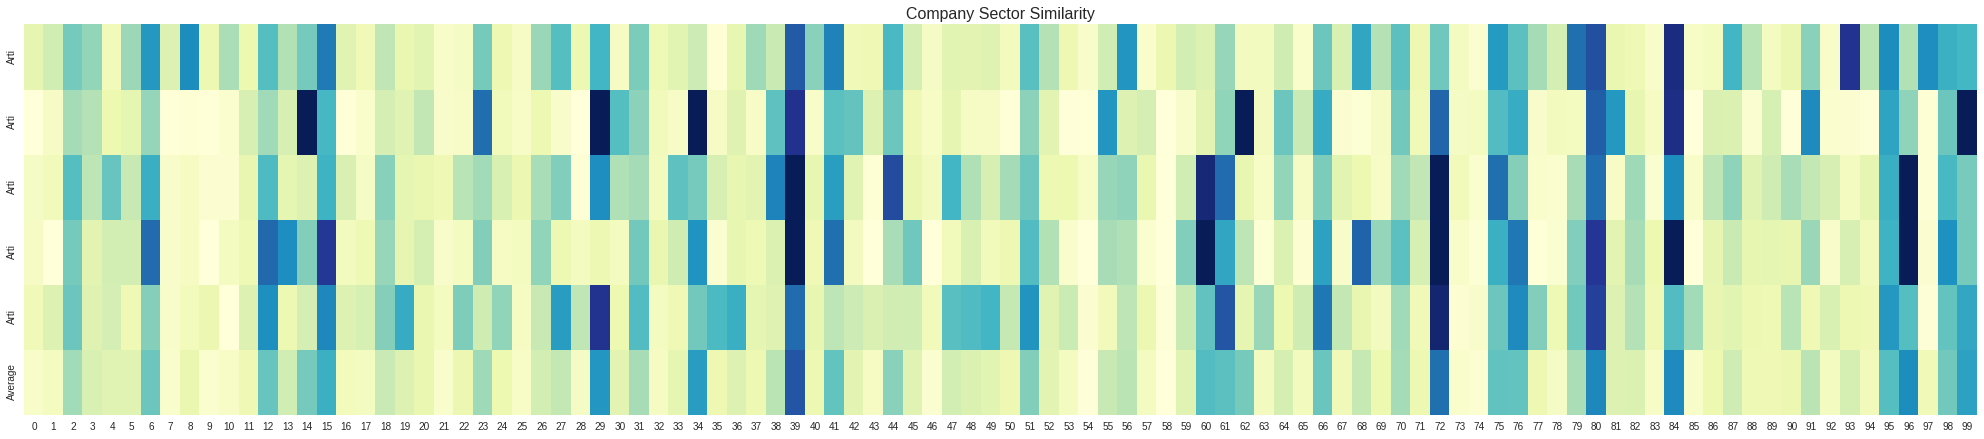

In [7]:
# Test visualization

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
n_topics=100

#Trained
#companies = [ (0, 70), (0, 80) ]  #Unrelated
#companies = [ (0, 100), (0, 194), (0, 192) ]  # Related Banks
#Test
companies = []
for i in range(0,5):
    companies.append((1,i))

topic_vectors = np.zeros([len(companies)+1,n_topics])
labels,i = [],0
for (s, num) in companies:
  by_topic=dat['doc_topic_dists'] if s==0 else doc_to_topic
  topic_vectors[i] = (by_topic[num])
  labels.append(names[num][:-4] if s==0 else test_names[num][:-4])  
  i+=1
    
av_by_topic = np.array( topic_vectors ).mean( axis=0 )
topic_vectors[i] = av_by_topic
labels.append("Average")

# doc_sim_list = []
# for j in range(503):
#     doc_topicav_sim = scipy.spatial.distance.cosine(dat['doc_topic_dists'][j],av_by_topic)
#     doc_sim_list += [(j,names[j],doc_topicav_sim)]
    
# sorted_docs_by_average = sorted(doc_sim_list, key=lambda x: x[2])
# similar_docs = [sorted_docs_by_average[idx] for idx in range(2)] 
# print similar_docs
# for doc in similar_docs:
#     i+=1
#     topic_vectors[i] = dat['doc_topic_dists'][doc[0]]
#     labels.append(doc[1])
    
    
# doc_sim_list = []
# for j in range(503):
#     doc_topicav_sim = abs(dat['doc_topic_dists'][j,20]-av_by_topic[20])
#     doc_sim_list += [(j,names[j],doc_topicav_sim)]
    
# sorted_docs_by_average = sorted(doc_sim_list, key=lambda x: x[2])
# similar_docs = [sorted_docs_by_average[idx] for idx in range(2)] 

# for doc in similar_docs:
#     i+=1
#     topic_vectors[i] = dat['doc_topic_dists'][doc[0]]
#     labels.append(doc[1])


plt.rcParams['figure.figsize']=(35,7)
ax = plt.axes()

rc={'font.size': 32, 'axes.labelsize': 32, 'legend.fontsize': 32.0, 
    'axes.titlesize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)

sns.heatmap(topic_vectors,cmap="YlGnBu",yticklabels=labels,robust=True,cbar=False)
ax.set_title('Company Sector Similarity')
plt.show()

## Heatmap and clustermap for articles vs articles

/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/seaborn-0.7.1-py2.7.egg/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/seaborn-0.7.1-py2.7.egg/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:
/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/seaborn-0.7.1-py2.7.egg/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/seaborn-0.7.1-py2.7.egg/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


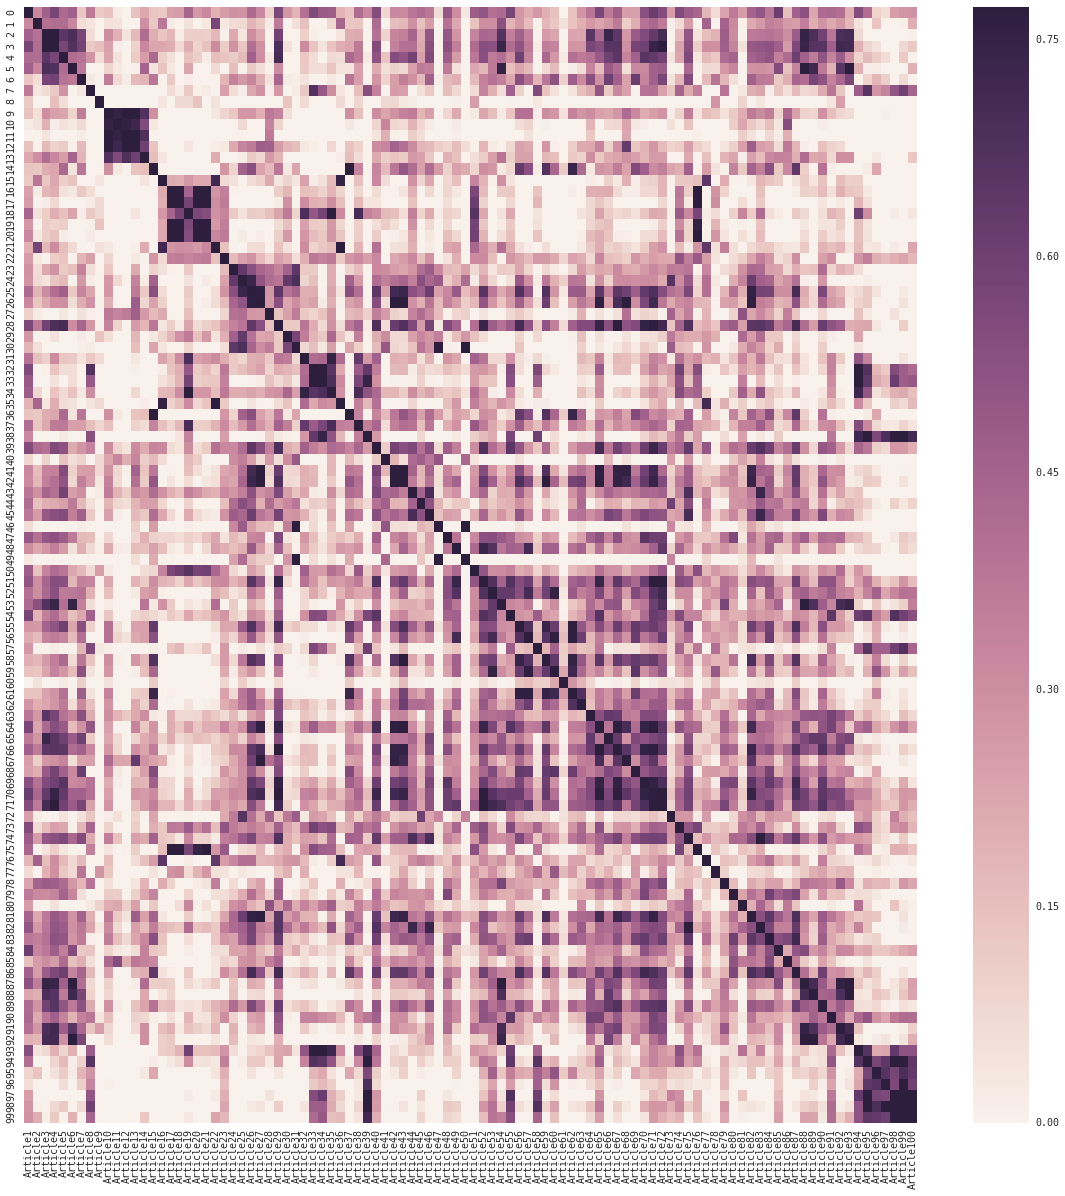

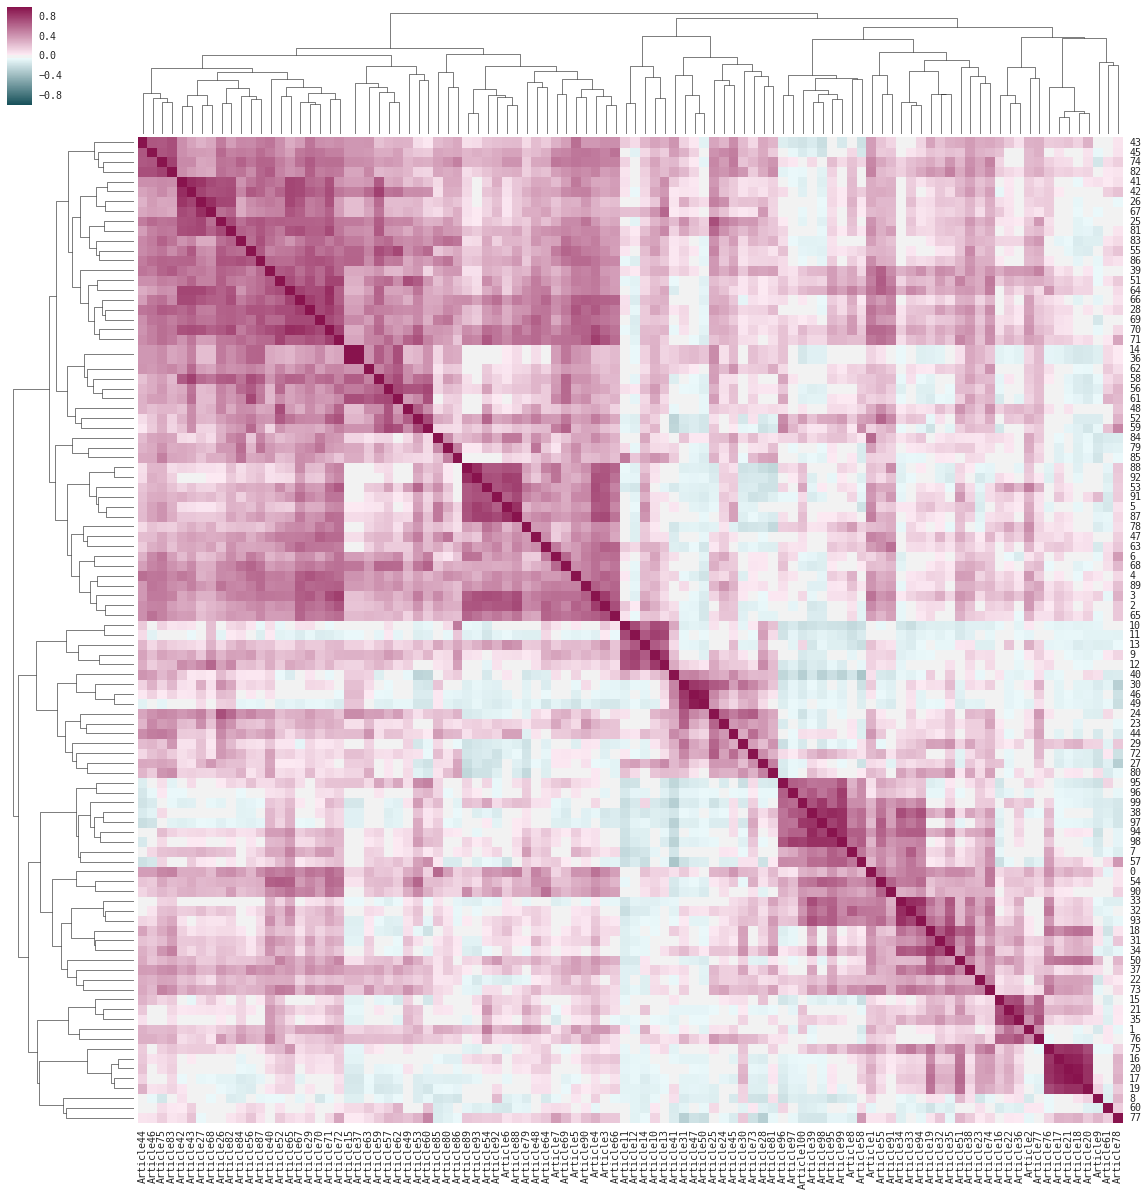

In [9]:
article_sim_matrix = np.zeros((len(doc_to_topic),len(doc_to_topic)))
for i in range(len(doc_to_topic)):
    for j in range(len(doc_to_topic)):
        article_sim_matrix[i,j] = 1-scipy.spatial.distance.correlation(doc_to_topic[i],doc_to_topic[j])
# for i in range(len(doc_to_topic)):
#     article_sim_matrix[i,i] = 1
        
df = pd.DataFrame(article_sim_matrix[0:100,0:100], columns=test_names[0:100])
sns.set(font="monospace")

# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
plt.rcParams['figure.figsize']=(20,20)
ax = plt.axes()

sns.heatmap(df,robust = True,vmin=0)

sns.clustermap(df,figsize=(20, 20), cmap=cmap)

## Heatmap and clustermap for articles vs predefined topics

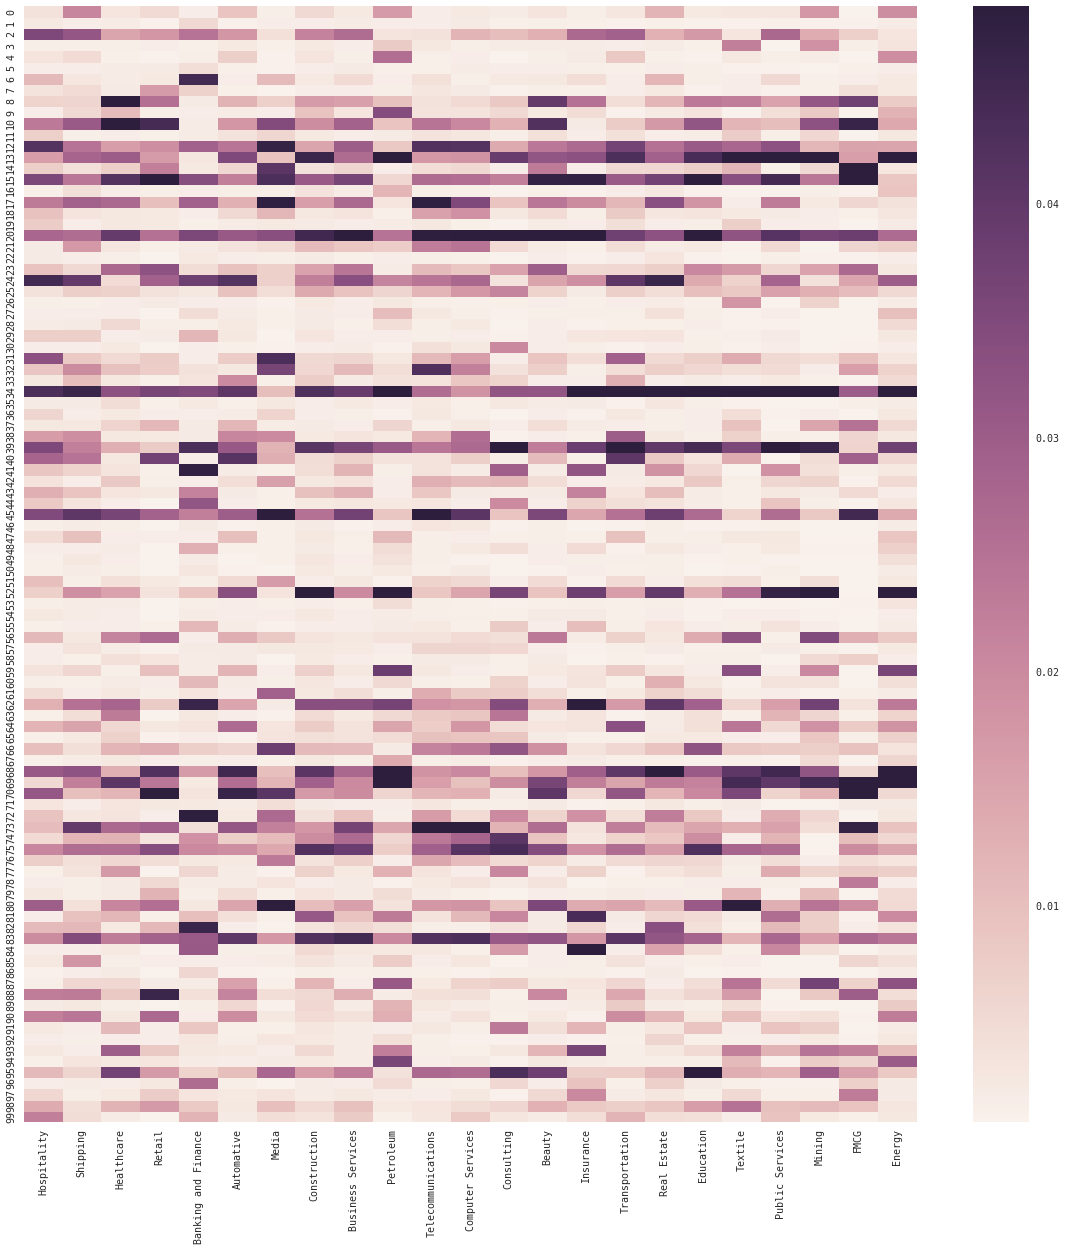

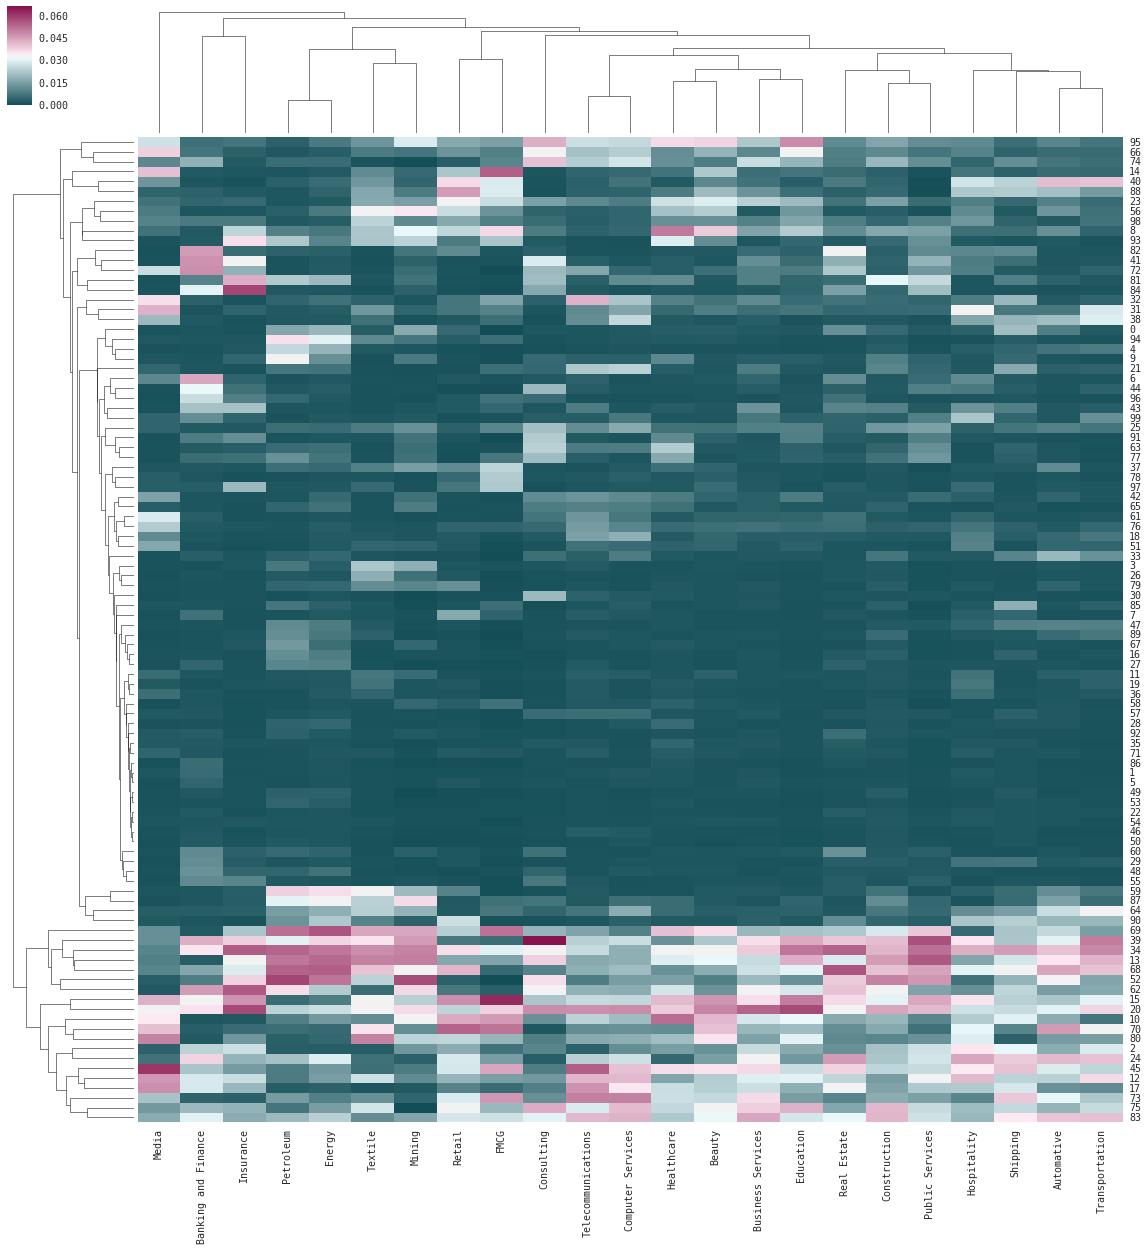

In [9]:
# Sort sectors by topic
sector_list = []

topic_sector_matrix = np.transpose(dat['doc_topic_dists'][503:526])
df = pd.DataFrame(topic_sector_matrix, columns=names[503:526])
sns.set(font="monospace")


# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
plt.rcParams['figure.figsize']=(20,20)
ax = plt.axes()

# Draw the full plot
# sns.clustermap(df, row_colors=network_colors, linewidths=.5,
#                col_colors=network_colors, figsize=(13, 13), cmap=cmap)
sns.heatmap(df,robust=True)
sns.clustermap(df,figsize=(20, 20), cmap=cmap)

# Histogram of a document vs topics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

c1 = 134
c2 = 447
row_idx = np.array([c1,c2])
print dat['doc_topic_dists'][row_idx[:]]
plt.rcParams['figure.figsize']=(30,10)
ax = plt.axes()


if c1<357:
    c1_name = names[c1+1][:-4]
elif c1>357:
    c1_name = names[c1][:-4]
    
if c2<357:
    c2_name = names[c2+1][:-4]
elif c2>357:
    c2_name = names[c2][:-4]


sns.heatmap(dat['doc_topic_dists'][row_idx[:]],cmap="YlGnBu",yticklabels=[c1_name,c2_name])
ax.set_title('Company Sector Similarity')
plt.show()

print dat['doc_topic_dists'][447]

<Container object of 100 artists>

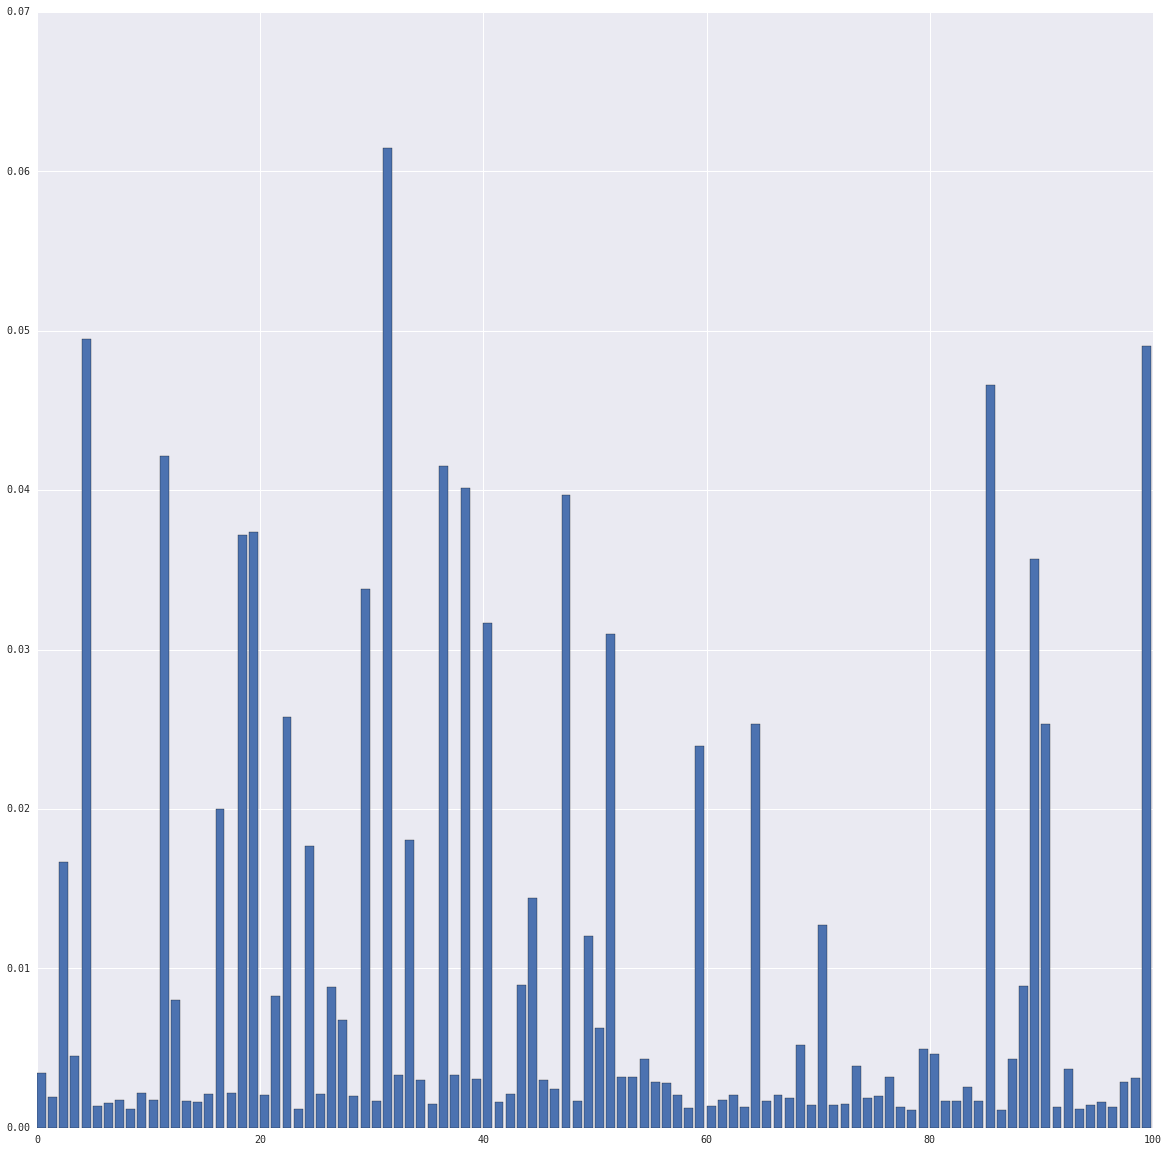

In [10]:
plt.bar(np.arange(100), dat['doc_topic_dists'][447])

## Get GICS descriptions, not used later

In [ ]:
wb = load_workbook(filename = 'testdata/GICS_map2014.xlsx')
sheet_list = wb['Descriptions']
file_ob = open("Description.txt",'a')
for i in range(6,346,2):
    s = 'H' + str(i)
    s1 = 'H' + str(i+1)
    print(sheet_list[s].value + ": " + sheet_list[s1].value) 
    file_ob.write(sheet_list[s].value + ": " + sheet_list[s1].value + "\n")
file_ob.close()

sector_dict = {}

with open("Description.txt") as f:
    content = f.readlines()
    for line in content:
        div = line.split(": ",1)
        sector_dict[div[0].lower()] = div[1].replace("\n","")
        
print len(sector_dict)